##### Copyright 2020 The TensorFlow Authors.

# CSC 594 HW\#4 XAI -- Integrated gradients (1): Explanations for ImageNet Categories
This code implements another XAI technique called IG (Integrated gradients), and demonstrates how it generates explanations for the predictions made by some off-the-shelf CNN models.  Those models are pretrained with ImageNet, and the code applies a few example images to classify them into ImageNet categories.

The code here is adapted from TensorFlow Tutorial (['Integrated gradients' under 'Interpretability](https://www.tensorflow.org/tutorials/interpretability/integrated_gradients)).


## Setup -- Google Drive Mounting

In [1]:
## Code piece to mount my Google Drive
from google.colab import drive 
drive.mount("/content/drive") # my Google root directory will be mapped here

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Change the working directory to the work directory (where the code and data files are).
import os
os.chdir('/content/drive/My Drive/CSC594ADL-2020fall/XAI')

# Ensure the files are there (in the folder)
!ls -l

total 3141
-rw------- 1 root root  492902 Oct 26 18:27 boathouselakerousseau1.jpg
-rw------- 1 root root  208133 Oct 26 18:25 boathouserow.jpg
-rw------- 1 root root 1494669 Nov  3 02:19 xai_integrated_gradients.ipynb
-rw------- 1 root root  629863 Oct 29 17:19 xai_lime_image.ipynb
-rw------- 1 root root  389122 Oct 30 20:59 xai_lime_image_rps.ipynb


### Imports
Import some of the necessary utilities for manipulation of images, plotting, CNN models and numerical analysis.

In [3]:
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf

np.random.seed(222)
print('Tensorflow version: ', tf.__version__)

Tensorflow version:  2.3.0


### (1) Load Pre-trained Models from Keras

We use models available at [Keras Applications](https://keras.io/api/applications/) which are pre-trained with ImageNet.
We take the whole model, including the top classification part (i.e., off-the-shelf), in this experiment.

For now, we use three CNN models (InceptionV3, VGG16 and ResNet50).  Note that, for all models, the parameter 'classification_activation' is set to None.  That's because the default activation function of the output layer is softmax for all of them, but for the model used in the original code, inception_v1, used None (i.e., logit).

In [4]:
# InceptionV3
iv3_model = tf.keras.applications.inception_v3.InceptionV3(weights='imagenet', 
                                                           include_top=True,
                                                           classifier_activation=None)

# VGG16
vgg16_model = tf.keras.applications.vgg16.VGG16(weights='imagenet', 
                                                include_top=True,
                                                classifier_activation=None)

# ResNet50
resnet50_model = tf.keras.applications.resnet50.ResNet50(weights='imagenet', 
                                                         include_top=True,
                                                         classifier_activation=None)

### (2) Load and pre-process images
First load a few example images. 

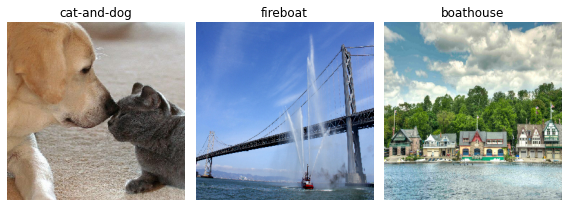

In [5]:
# Load three images: two images from a URL and another from local drive.  
# The obtained images (orig_imgX) are still in the PIL Image format at this time.
# Note: All images are uniformly sized to (299,299) for now.
from IPython.display import Image

img_target_size = (299,299)

# image1:
path1 = tf.keras.utils.get_file("cat-and-dog.jpg", "https://arteagac.github.io/blog/lime_image/img/cat-and-dog.jpg")
orig_img1 = tf.keras.preprocessing.image.load_img(path1, target_size=img_target_size)

# image2:
path2 = tf.keras.utils.get_file("San_Francisco_fireboat_showing_off.jpg", 'http://storage.googleapis.com/download.tensorflow.org/example_images/San_Francisco_fireboat_showing_off.jpg')
orig_img2 = tf.keras.preprocessing.image.load_img(path2, target_size=img_target_size)

# image3:
orig_img3 = tf.keras.preprocessing.image.load_img('boathouserow.jpg', target_size=img_target_size)

#---------------
# Put them in a dictionary with image names
img_names = ['cat-and-dog', 'fireboat', 'boathouse']
imagenet_indices = [208, 554, 449]
img_name_map = {img_names[0] : orig_img1, img_names[1] : orig_img2, img_names[2] : orig_img3}

# Display the images
plt.figure(figsize=(8, 8))
for n, (name, orig_img) in enumerate(img_name_map.items()):
  ax = plt.subplot(1, 3, n+1)
  ax.imshow(orig_img)
  ax.set_title(name)
  ax.axis('off')
plt.tight_layout()

In [6]:
# Functions to preprocess an image, for a specific model.
import copy

def preprocess_image_for_model(orig_img, model_type):
  # First make a copy of the original image
  img = copy.deepcopy(orig_img)

  # Next make the img to the appropriate target size
  if model_type.startswith('inception') or model_type.startswith('mobilenet') or model_type == 'xception':
    target_size = (299, 299)
  else:
    target_size = (224, 224) # all other models use this size

  if img.size != target_size:
    img = img.resize(target_size)

  # Convert the image pixels to a (3D) numpy array
  x = tf.keras.preprocessing.image.img_to_array(img)

  # Finally call the appropriate 'process_input()' function for the model.
  # The function only scale the pixel values expected for the model (either [0,1] or [-1,1]).
  if model_type.startswith('inception') or model_type == 'xception': # anomaly, [-1,1]
    x = tf.keras.applications.inception_v3.preprocess_input(x)
  else:
    x = tf.keras.applications.vgg16.preprocess_input(x) # [0,1], vgg16 as the representative

  return x

### (3) Run Models and Obtain Predictions
Run the models and obtain predictions for each image.  For each model, the output of the classification is a vector of 1000 logits corresponding the categories in ImageNet.

We also save the top-K predictions (actually their indices in ImageNet) for future use.

In [7]:
# Set k in top_k to be 5 for now
topk = 5

In [8]:
# (3-1) InceptionV3 -- Look for 'iv3' in the lines

# Save the processed images and the prediction results in dictionaries
images_iv3 = {}
results_iv3 = {}

for (name, orig_img) in img_name_map.items():
  # First process the image
  processed_image = preprocess_image_for_model(orig_img, 'inceptionv3')
  images_iv3[name] = processed_image
  #print (processed_image.shape) # to ensure processing was successful

  # Run the model to obtain predictions
  # To do so, add the 0th dimension (batch_size) to make the image a 4D tensor (on the fly)
  preds = iv3_model.predict(np.expand_dims(processed_image, axis=0))
  top_pred_classes = preds[0].argsort()[-topk:][::-1] # indices of topk classes
  
  # 'Decode' the predictions
  results = tf.keras.applications.inception_v3.decode_predictions(preds, top=topk)[0]
  results_iv3[name] = [(index, result[1], result[2]) for index, result in zip(top_pred_classes, results)]

print (results_iv3)

{'cat-and-dog': [(208, 'Labrador_retriever', 8.894074), (180, 'American_Staffordshire_terrier', 5.394669), (207, 'golden_retriever', 4.544377), (246, 'Great_Dane', 4.513929), (243, 'bull_mastiff', 4.465603)], 'fireboat': [(554, 'fireboat', 9.115503), (718, 'pier', 6.282951), (839, 'suspension_bridge', 3.9334447), (562, 'fountain', 2.932416), (510, 'container_ship', 2.675306)], 'boathouse': [(449, 'boathouse', 9.278532), (975, 'lakeside', 4.809432), (208, 'Labrador_retriever', 2.6258864), (483, 'castle', 2.5265274), (408, 'amphibian', 2.425071)]}


In [9]:
# (3-2) VGG16 -- Look for 'vgg16' in the lines

# Save the processed images and the prediction results in dictionaries
images_vgg16 = {}
results_vgg16 = {}

for (name, orig_img) in img_name_map.items():
  # First process the image
  processed_image = preprocess_image_for_model(orig_img, 'vgg16') 
  #print (processed_image.shape) # to ensure processing was successful
  images_vgg16[name] = processed_image

  # Run the model to obtain predictions
  # To do so, add the 0th dimension (batch_size) to make the image a 4D tensor (on the fly)
  preds = vgg16_model.predict(np.expand_dims(processed_image, axis=0))
  top_pred_classes = preds[0].argsort()[-topk:][::-1]

  # 'Decode' the predictions
  results = tf.keras.applications.vgg16.decode_predictions(preds, top=topk)[0]
  results_vgg16[name] = [(index, result[1], result[2]) for index, result in zip(top_pred_classes, results)]

print (results_vgg16)

{'cat-and-dog': [(208, 'Labrador_retriever', 6.2988944), (180, 'American_Staffordshire_terrier', 5.838131), (207, 'golden_retriever', 5.263995), (273, 'dingo', 5.103413), (179, 'Staffordshire_bullterrier', 5.0900035)], 'fireboat': [(554, 'fireboat', 18.32759), (718, 'pier', 13.106116), (510, 'container_ship', 11.469873), (540, 'drilling_platform', 11.313546), (628, 'liner', 11.118918)], 'boathouse': [(449, 'boathouse', 12.775321), (975, 'lakeside', 11.761783), (977, 'sandbar', 8.507534), (536, 'dock', 8.267135), (576, 'gondola', 7.750292)]}


In [10]:
# (3-3) ResNet50 -- Look for 'resnet50' in the lines

# Save the processed images and the prediction results in dictionaries
images_resnet50 = {}
results_resnet50 = {}

for (name, orig_img) in img_name_map.items():
  # First process the image
  processed_image = preprocess_image_for_model(orig_img, 'resnet50') 
  images_resnet50[name] = processed_image
  #print (processed_image.shape) # to ensure processing was successful

  # Run the model to obtain predictions
  # To do so, add the 0th dimension (batch_size) to make the image a 4D tensor (on the fly)
  preds = resnet50_model.predict(np.expand_dims(processed_image, axis=0))
  top_pred_classes = preds[0].argsort()[-topk:][::-1]

  # 'Decode' the predictions
  results = tf.keras.applications.resnet50.decode_predictions(preds, top=topk)[0]
  results_resnet50[name] = [(index, result[1], result[2]) for index, result in zip(top_pred_classes, results)]

print (results_resnet50)

{'cat-and-dog': [(208, 'Labrador_retriever', 14.698072), (207, 'golden_retriever', 10.177761), (209, 'Chesapeake_Bay_retriever', 9.082241), (260, 'chow', 8.365825), (222, 'kuvasz', 8.316446)], 'fireboat': [(554, 'fireboat', 17.29013), (718, 'pier', 14.649561), (839, 'suspension_bridge', 12.412793), (517, 'crane', 9.556543), (628, 'liner', 9.520776)], 'boathouse': [(449, 'boathouse', 13.2050295), (975, 'lakeside', 12.881824), (536, 'dock', 11.061066), (977, 'sandbar', 9.453406), (483, 'castle', 9.373209)]}


## (4) Integrated Gradients explanations

From here on, we focus on one CNN model and one example image at a time.  

**NOTE**: You can change the values and code here for your experimentation.

In [11]:
# Define the model to use and its associated variables saved earlier.
# Change these for other models when you experiment.
model_type = 'inceptionv3' 
model = iv3_model #
image_map = images_iv3
results_map = results_iv3

# Define the image to use
image_name_to_use = img_names[0]     # 'Labrador retriever'
imagenet_index = imagenet_indices[0] # imagenet index for the chosen image

Xi = image_map[image_name_to_use] # Xi is the orig_img
image_shape = Xi.shape
print (image_shape)

# Fix up the image just for displaying (because inception's [-1,1] range 
# causes problems for displaying image with boundaries).
if (model_type.startswith('inception') or model_type.startswith('mobilenet') or model_type == 'xception'):
  img2 = Xi/2+0.5
else:
  img2 = Xi

(299, 299, 3)


## (4.1) Calculate Integrated Gradients

### (4.1.1) Establish a baseline

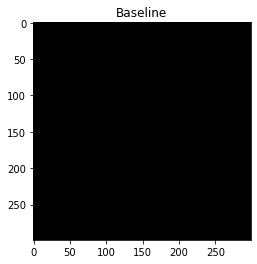

In [12]:
baseline = tf.zeros(shape=image_shape)

plt.imshow(baseline)
plt.title("Baseline")
#plt.axis('off')
plt.show()

### (4.1.2) Unpack formulas into code

The formula for Integrated Gradients is as follows:

$IntegratedGradients_{i}(x) ::= (x_{i} - x'_{i})\times\int_{\alpha=0}^1\frac{\partial F(x'+\alpha \times (x - x'))}{\partial x_i}{d\alpha}$

where:

$_{i}$ = feature   
$x$ = input  
$x'$ = baseline   
$\alpha$ = interpolation constant to perturbe features by

In practice, computing a definite integral is not always numerically possible and can be computationally costly, so you compute the following numerical approximation:

$IntegratedGrads^{approx}_{i}(x)::=(x_{i}-x'_{i})\times\sum_{k=1}^{m}\frac{\partial F(x' + \frac{k}{m}\times(x - x'))}{\partial x_{i}} \times \frac{1}{m}$

where:

$_{i}$ = feature (individual pixel)  
$x$ = input (image tensor)  
$x'$ = baseline (image tensor)  
$k$ = scaled feature perturbation constant  
$m$ = number of steps in the Riemann sum approximation of the integral  
$(x_{i}-x'_{i})$ = a term for the difference from the baseline. This is necessary to scale the integrated gradients and keep them in terms of the original image. The path from the baseline image to the input is in pixel space. Since with IG you are integrating in a straight line (linear transformation) this ends up being roughly equivalent to the integral term of the derivative of the interpolated image function with respect to $\alpha$ with enough steps. The integral sums each pixel's gradient times the change in the pixel along the path. It's simpler to implement this integration as uniform steps from one image to the other, substituting $x := (x' + \alpha(x-x'))$. So the change of variables gives $dx = (x-x')d\alpha$. The $(x-x')$ term is constant and is factored out of the integral.

### (4.1.3) Interpolate images

$IntegratedGrads^{approx}_{i}(x)::=(x_{i}-x'_{i})\times\sum_{k=1}^{m}\frac{\partial F(\overbrace{x' + \frac{k}{m}\times(x - x')}^\text{interpolate m images at k intervals})}{\partial x_{i}} \times \frac{1}{m}$

First, you will generate a [linear interpolation](https://en.wikipedia.org/wiki/Linear_interpolation) between the baseline and the original image. You can think of interpolated images as small steps in the feature space between your baseline and input, represented by $\alpha$ in the original equation.

In [13]:
m_steps=50
alphas = tf.linspace(start=0.0, stop=1.0, num=m_steps+1) # Generate m_steps intervals for integral_approximation() below.

In [14]:
# assume pixel values of input image [0,1]; returns 
# interpolated images with [0,1] as well (convenient for visualization)
def interpolate_images(baseline,
                       image,
                       alphas):
  alphas_x = alphas[:, tf.newaxis, tf.newaxis, tf.newaxis]
  baseline_x = tf.expand_dims(baseline, axis=0)
  input_x = tf.expand_dims(image, axis=0)
  delta = input_x - baseline_x
  images = baseline_x +  alphas_x * delta
  return images

Let's use the above function to generate interpolated images along a linear path at alpha intervals between a black baseline image and the example image.

In [15]:
interpolated_images = interpolate_images(
    baseline=baseline,
    #image=img_name_tensors['Fireboat'],
    image = img2, # values in [0,1]
    alphas=alphas)

Let's visualize the interpolated images. Note: another way of thinking about the $\alpha$ constant is that it is consistently increasing each interpolated image's intensity.

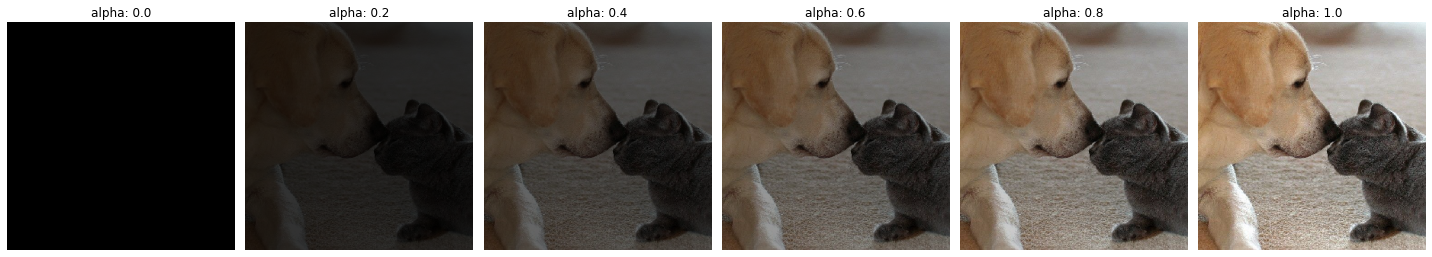

In [16]:
fig = plt.figure(figsize=(20, 20))

i = 0
for alpha, image in zip(alphas[0::10], interpolated_images[0::10]):
  i += 1
  plt.subplot(1, len(alphas[0::10]), i)
  plt.title(f'alpha: {alpha:.1f}')
  plt.imshow(image)
  plt.axis('off')

plt.tight_layout();

### (4.1.4) Compute gradients

Now let's take a look at how to calculate gradients in order to measure the relationship between changes to a feature and changes in the model's predictions. In the case of images, the gradient tells us which pixels have the strongest effect on the models predicted class probabilities.

$IntegratedGrads^{approx}_{i}(x)::=(x_{i}-x'_{i})\times\sum_{k=1}^{m}\frac{\overbrace{\partial F(\text{interpolated images})}^\text{compute gradients}}{\partial x_{i}} \times \frac{1}{m}$

where:  
$F()$ = your model's prediction function  
$\frac{\partial{F}}{\partial{x_i}}$ = gradient (vector of partial derivatives $\partial$) of your model F's prediction function relative to each feature $x_i$

TensorFlow makes computing gradients easy for you with a [`tf.GradientTape`](https://www.tensorflow.org/api_docs/python/tf/GradientTape).

In [17]:
# assume pixel values of input images appropriate for the model
# (thus [-1,1] or [0,1])
def compute_gradients(images, target_class_idx):
  with tf.GradientTape() as tape:
    tape.watch(images)
    logits = model(images)
    probs = tf.nn.softmax(logits, axis=-1)[:, target_class_idx]
  return tape.gradient(probs, images)

Let's compute the gradients for each image along the interpolation path with respect to the correct output. Recall that your model returns a `(1, 1000)` shaped `Tensor` with logits that you convert to predicted probabilities for each class. You need to pass the correct ImageNet target class index to the `compute_gradients` function for your image.

In [18]:
## We must convert interpolated_images to the pixel values appropriate for the model.
## The fixed variable is 'int_images_for_prediction'
if (model_type.startswith('inception') or model_type.startswith('mobilenet') or model_type == 'xception'):
  int_images_for_prediction = interpolated_images * 2 - 1.0
else:
  int_images_for_prediction = interpolated_images

# use 'int_images_for_prediction' to compute gradients
path_gradients = compute_gradients(
    images=int_images_for_prediction, #interpolated_images,
    target_class_idx=imagenet_index) #555)

Note the output shape of `(n_interpolated_images, img_height, img_width, RGB)`, which gives us the gradient for every pixel of every image along the interpolation path. You can think of these gradients as measuring the change in your model's predictions for each small step in the feature space.

In [19]:
print(path_gradients.shape)

(51, 299, 299, 3)


**Visualizing gradient saturation**

Recall that the gradients you just calculated above describe *local* changes to your model's predicted probability of the target image class and can *saturate*.

These concepts are visualized using the gradients you calculated above in the 2 plots below.

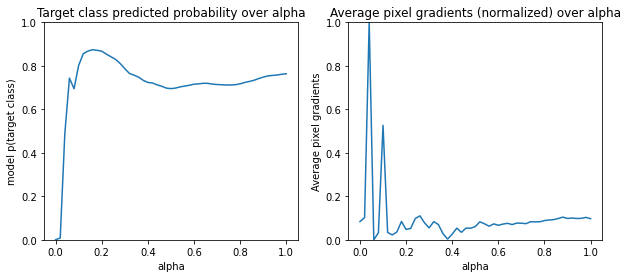

In [20]:
pred = model(int_images_for_prediction)#interpolated_images)
pred_proba = tf.nn.softmax(pred, axis=-1)[:, imagenet_index]#555]
#print (pred_proba)

plt.figure(figsize=(10, 4))
ax1 = plt.subplot(1, 2, 1)
ax1.plot(alphas, pred_proba)
ax1.set_title('Target class predicted probability over alpha')
ax1.set_ylabel('model p(target class)')
ax1.set_xlabel('alpha')
ax1.set_ylim([0, 1])

ax2 = plt.subplot(1, 2, 2)
# Average across interpolation steps
average_grads = tf.reduce_mean(path_gradients, axis=[1, 2, 3])
# Normalize gradients to 0 to 1 scale. E.g. (x - min(x))/(max(x)-min(x))
average_grads_norm = (average_grads-tf.math.reduce_min(average_grads))/(tf.math.reduce_max(average_grads)-tf.reduce_min(average_grads))
ax2.plot(alphas, average_grads_norm)
ax2.set_title('Average pixel gradients (normalized) over alpha')
ax2.set_ylabel('Average pixel gradients')
ax2.set_xlabel('alpha')
ax2.set_ylim([0, 1]);

* **left**: This plot shows how your model's confidence in the target class varies across alphas. Notice how the gradients, or slope of the line, largely saturates around 0.2 before settling at the final  predicted probability of about 80%.

* **right**: The right plot shows the average gradients magnitudes over alpha more directly. Note how the values sharply approach and even briefly dip below zero. In fact, your model "learns" the most from gradients at lower values of alpha before saturating. Intuitively, you can think of this as your model has learned the pixels to make the correct prediction, sending these pixels gradients to zero, but is still quite uncertain and focused on spurious objects as the alpha values approach the original input image.

To make sure these important water cannon pixels are reflected as important to the target prediction, you will continue on below to learn how to accumulate these gradients to accurately approximate how each pixel impacts your target predicted probability.


### (4.1.5) Accumulate gradients (integral approximation)

There are many different ways you can go about computing the numerical approximation of an integral for IG with different tradeoffs in accuracy and convergence across varying functions. A popular class of methods is called [Riemann sums](https://en.wikipedia.org/wiki/Riemann_sum). Here, you will use the Trapezoidal rule (you can find additional code to explore different approximation methods at the end of this tutorial).

$IntegratedGrads^{approx}_{i}(x)::=(x_{i}-x'_{i})\times \overbrace{\sum_{k=1}^{m}}^\text{Sum m local gradients}
\text{gradients(interpolated images)} \times \overbrace{\frac{1}{m}}^\text{Divide by m steps}$

From the equation, you can see you are summing over `m` gradients and dividing by `m` steps. You can implement the two operations together for part 3 as an *average of the local gradients of `m` interpolated predictions and input images*.

In [21]:
def integral_approximation(gradients):
  # riemann_trapezoidal
  grads = (gradients[:-1] + gradients[1:]) / tf.constant(2.0)
  integrated_gradients = tf.math.reduce_mean(grads, axis=0)
  return integrated_gradients

The `integral_approximation` function takes the gradients of the predicted probability of the target class with respect to the interpolated images between the baseline and the original image.

In [22]:
ig = integral_approximation(
    gradients=path_gradients)

You can confirm averaging across the gradients of `m` interpolated images returns an integrated gradients tensor with the same shape as the original image.

In [23]:
print(ig.shape)

(299, 299, 3)


### (4.1.6) Putting it all together

Now you will combine the 3 previous general parts together into an `IntegratedGradients` function and utilize a [@tf.function](https://www.tensorflow.org/guide/function) decorator to compile it into a high performance callable TensorFlow graph. This is implemented as 5 smaller steps below:


$IntegratedGrads^{approx}_{i}(x)::=\overbrace{(x_{i}-x'_{i})}^\text{5.}\times \overbrace{\sum_{k=1}^{m}}^\text{4.} \frac{\partial \overbrace{F(\overbrace{x' + \overbrace{\frac{k}{m}}^\text{1.}\times(x - x'))}^\text{2.}}^\text{3.}}{\partial x_{i}} \times \overbrace{\frac{1}{m}}^\text{4.}$

1. Generate alphas $\alpha$

2. Generate interpolated images = $(x' + \frac{k}{m}\times(x - x'))$

3. Compute gradients between model $F$ output predictions with respect to input features = $\frac{\partial F(\text{interpolated path inputs})}{\partial x_{i}}$

4. Integral approximation through averaging gradients = $\sum_{k=1}^m \text{gradients} \times \frac{1}{m}$

5. Scale integrated gradients with respect to original image = $(x_{i}-x'_{i}) \times \text{integrated gradients}$. The reason this step is necessary is to make sure that the attribution values accumulated across multiple interpolated images are in the same units and faithfully represent the pixel importances on the original image.

In [24]:
@tf.function
def integrated_gradients(baseline,
                         image,
                         target_class_idx,
                         m_steps=50,
                         batch_size=32):
  # 1. Generate alphas.
  alphas = tf.linspace(start=0.0, stop=1.0, num=m_steps+1)

  # Initialize TensorArray outside loop to collect gradients.    
  gradient_batches = tf.TensorArray(tf.float32, size=m_steps+1)
    
  # Iterate alphas range and batch computation for speed, memory efficiency, and scaling to larger m_steps.
  for alpha in tf.range(0, len(alphas), batch_size):
    from_ = alpha
    to = tf.minimum(from_ + batch_size, len(alphas))
    alpha_batch = alphas[from_:to]

    # 2. Generate interpolated inputs between baseline and input.
    interpolated_path_input_batch = interpolate_images(baseline=baseline,
                                                       image=image,
                                                       alphas=alpha_batch)

    # 3. Compute gradients between model outputs and interpolated inputs.
    gradient_batch = compute_gradients(images=interpolated_path_input_batch,
                                       target_class_idx=target_class_idx)
    
    # Write batch indices and gradients to extend TensorArray.
    gradient_batches = gradient_batches.scatter(tf.range(from_, to), gradient_batch)    
  
  # Stack path gradients together row-wise into single tensor.
  total_gradients = gradient_batches.stack()

  # 4. Integral approximation through averaging gradients.
  avg_gradients = integral_approximation(gradients=total_gradients)

  # 5. Scale integrated gradients with respect to input.
  integrated_gradients = (image - baseline) * avg_gradients

  return integrated_gradients

In [25]:
ig_attributions = integrated_gradients(baseline=baseline,
                                       #image=img_name_tensors['Fireboat'],
                                       image = img2, 
                                       target_class_idx=imagenet_index, #555,
                                       m_steps=240)

Again, you can check that the IG feature attributions have the same shape as the input image.

In [26]:
print(ig_attributions.shape)

(299, 299, 3)


The paper suggests the number of steps to range between 20 to 300 depending upon the example (although in practice this can be higher in the 1,000s to accurately approximate the integral). You can find additional code to check for the appropriate number of steps in the "Next steps" resources at the end of this tutorial.

### (4.2) Visualize attributions

You are ready to visualize attributions, and overlay them on the original image. The code below sums the absolute values of the integrated gradients across the color channels to produce an attribution mask. This plotting method captures the relative impact of pixels on the model's predictions. 

In [27]:
def plot_img_attributions(baseline,
                          image,
                          target_class_idx,
                          m_steps=50,
                          cmap=None,
                          overlay_alpha=0.4):

  attributions = integrated_gradients(baseline=baseline,
                                      image=img2,#image,
                                      target_class_idx=target_class_idx,
                                      m_steps=m_steps)

  # Sum of the attributions across color channels for visualization.
  # The attribution mask shape is a grayscale image with height and width
  # equal to the original image.
  attribution_mask = tf.reduce_sum(tf.math.abs(attributions), axis=-1)

  fig, axs = plt.subplots(nrows=2, ncols=2, squeeze=False, figsize=(8, 8))

  axs[0, 0].set_title('Baseline image')
  axs[0, 0].imshow(baseline)
  axs[0, 0].axis('off')

  axs[0, 1].set_title('Original image')
  axs[0, 1].imshow(image)
  axs[0, 1].axis('off')

  axs[1, 0].set_title('Attribution mask')
  axs[1, 0].imshow(attribution_mask, cmap=cmap)
  axs[1, 0].axis('off')

  axs[1, 1].set_title('Overlay')
  axs[1, 1].imshow(attribution_mask, cmap=cmap)
  axs[1, 1].imshow(image, alpha=overlay_alpha)
  axs[1, 1].axis('off')

  plt.tight_layout()
  return fig

Looking at the attributions on the example image, you can see the model identifies the face of the dog as contributing to its correct prediction.

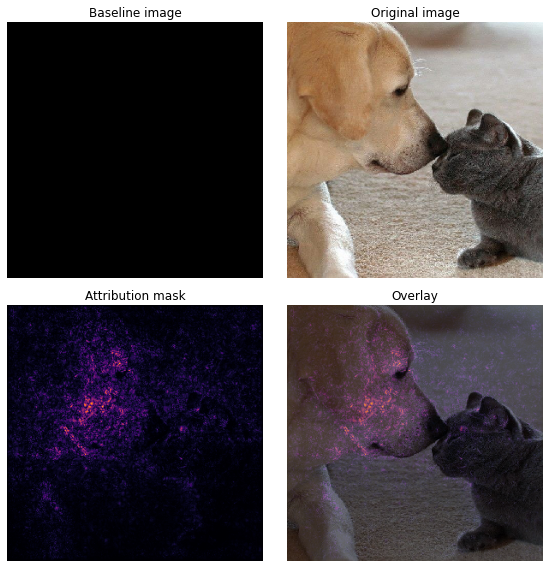

In [28]:
_ = plot_img_attributions(image=img2,#img_name_tensors['Fireboat'],
                          baseline=baseline,
                          target_class_idx=imagenet_index,#555,
                          m_steps=240,
                          cmap=plt.cm.inferno,
                          overlay_alpha=0.4)

## (4.3) Uses and limitations

Use cases
* Employing techniques like Integrated Gradients before deploying your model can help you develop intuition for how and why it works. Do the features highlighted by this technique match your intuition? If not, that may be indicative of a bug in your model or dataset, or overfitting.

Limitations
* Integrated Gradients provides feature importances on individual examples, however, it does not provide global feature importances across an entire dataset.

* Integrated Gradients provides individual feature importances, but it does not explain feature interactions and combinations.